In [240]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [278]:
df = pd.read_csv('processed_rides.csv', parse_dates=['end_date', 'start_date'])
df.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029,0


#### 1) Подготовить таблицу с почасовым трафиком в каждой точке. (Сколько приехало и уехало)

In [264]:
traffic_data = {}

# Уникальные локации
locations = pd.concat([df['start_location'], df['end_location']]).unique()

for location in locations:
    # Аггрегируем приезды и отьезды по часам
    arrivals = df[df['end_location'] == location].resample('h', on='end_date').size()
    departures = df[df['start_location'] == location].resample('h', on='start_date').size()

    # Добавление в словарь
    traffic_data[location + '_П'] = arrivals # Приезд
    traffic_data[location + '_О'] = departures # Отъезд

    # traffic_data[location + '_В'] = arrivals.add(departures, fill_value=0) # Приезд + Отъезд = Всего

# Новый DataFrame
traffic_by_hours = pd.DataFrame(traffic_data).fillna(0).astype(int)

# Месяц временной метки
traffic_by_hours['month'] = traffic_by_hours.index.month_name(locale='ru')

traffic_by_hours.head()

,шевченко_П,шевченко_О,чехова_П,чехова_О,буденного_П,буденного_О,труда_П,труда_О,первомайская_П,первомайская_О,...,чапаева_О,степная_П,степная_О,трудовая_П,трудовая_О,железнодорожная_П,железнодорожная_О,мира_П,мира_О,month
2023-04-22 09:00:00,0,1,0,2,0,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,Апрель
2023-04-22 10:00:00,1,0,0,0,0,2,0,1,1,0,...,0,1,0,1,0,0,0,0,0,Апрель
2023-04-22 11:00:00,0,0,0,0,0,1,0,0,0,1,...,0,1,0,2,0,1,0,0,0,Апрель
2023-04-22 12:00:00,0,0,0,2,1,0,0,0,1,0,...,0,0,0,0,0,0,0,2,0,Апрель
2023-04-22 13:00:00,0,0,0,3,2,4,0,0,1,1,...,0,0,0,1,0,2,0,0,0,Апрель


#### 2) Определить топ-3 точки с самым высоким трафиком. 
1. Есть ли точки, которые можно закрыть? 
2. Какие самые популярные направления перемещения? 
3. Есть ли необходимость в конце дня перераспределять самокаты по точкам?


##### Топ-3 точки по общему трафику

In [275]:
top = ((df['start_location'].value_counts() + df['end_location'].value_counts()).to_frame()).sort_values('count', ascending=False)

top.head(3)

,count
луговая,4530
ломоносова,4499
спортивная,4461


##### Топ-3 начальных и конечных точек

In [195]:
top_start = df['start_location'].value_counts().to_frame()
top_end = df['end_location'].value_counts().to_frame()

top_start.head(3)

,count
start_location,
луговая,2276
ломоносова,2274
майская,2216


In [194]:
top_end.head(3)

,count
end_location,
спортивная,2293
восточная,2270
буденного,2267


##### 2.1 Есть ли точки, которые можно закрыть?

Чтобы ответить на этот вопрос провизуализируем трафик в каждой точке за все время наблюдения

In [236]:
# Из трафика по часам создаем новый датафрейм где содержится информация о приездах и отьездах из локации за все время
traffic = traffic_by_hours.melt(var_name='location_type', value_name='count')
traffic[['location', 'type']] = traffic['location_type'].str.split('_', expand=True)
traffic = traffic.drop('location_type', axis=1)

traffic['type'] = traffic['type'].map({'О': "Отъезд", "П": "Приезд"})
traffic = traffic.groupby(['location', 'type'], as_index=False)['count'].sum()

traffic.head()

,location,type,count
0,береговая,Отъезд,865
1,береговая,Приезд,826
2,березовая,Отъезд,1224
3,березовая,Приезд,1212
4,буденного,Отъезд,2173


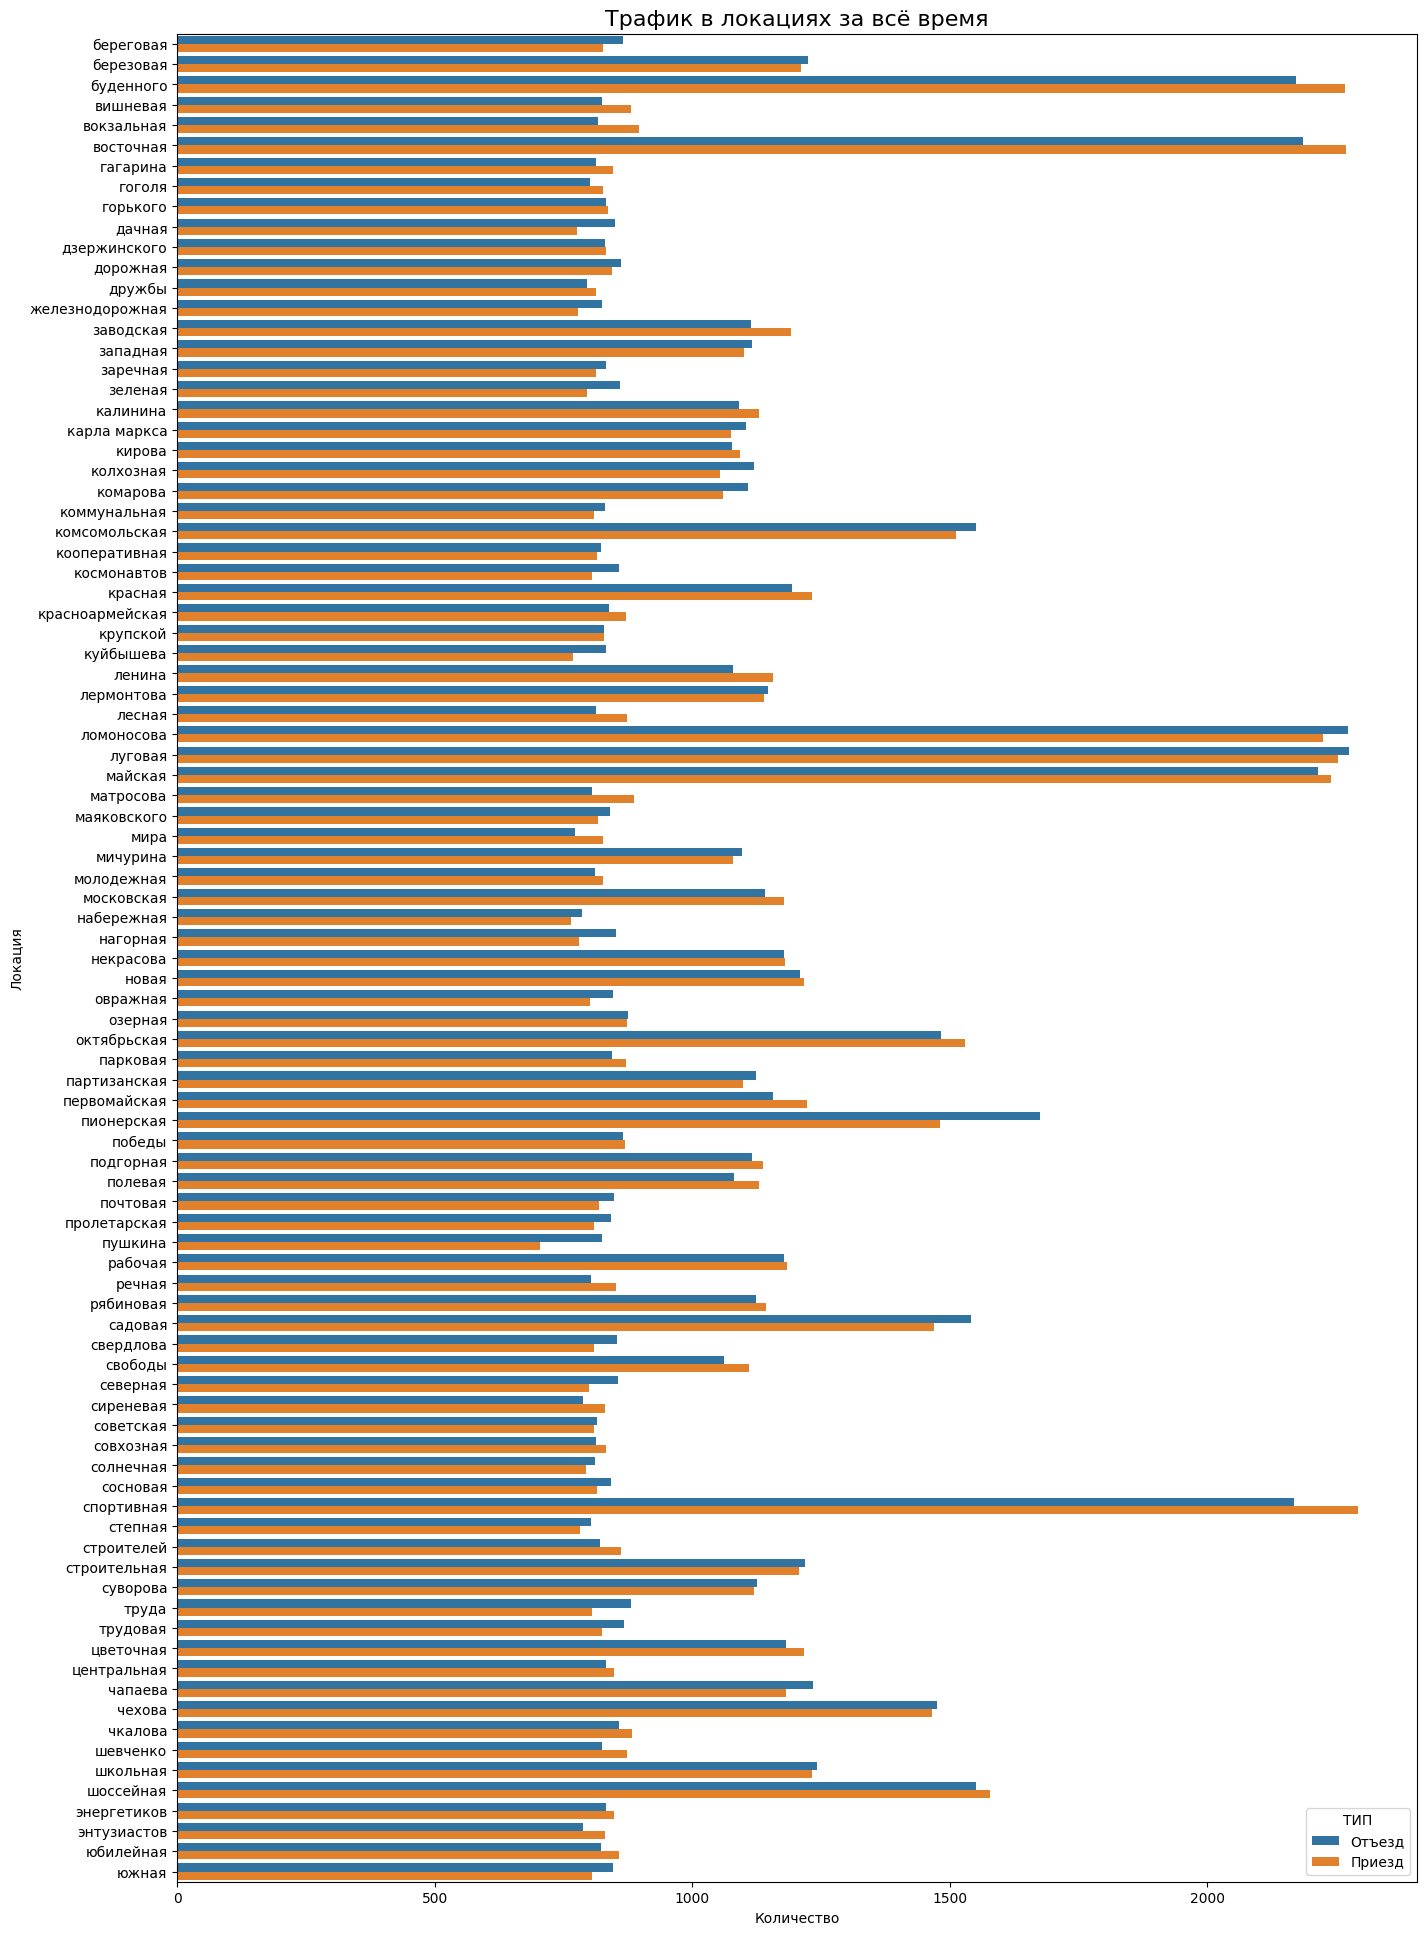

In [ ]:
# Провизуализируем данные
plt.figure(figsize=(16, 24))
sns.barplot(traffic, y='location', x='count', hue='type')

plt.title('Трафик в локациях за всё время', fontsize=16)
plt.legend(title='ТИП')

plt.xlabel('Количество')
plt.ylabel('Локация')

plt.show()

По представленной информации сложно сказать стоит ли закрывать какие-либо точки, посмотрим на трафик в точках по месяцам

In [265]:
traffic_by_months = traffic_by_hours.groupby('month').sum().iloc[1:] # Не берем данные за август, они не значительны

months_order = ['Апрель', 'Май', 'Июнь', 'Июль']

# Преобразование индексов для правильной сортировки месяцов
traffic_by_months.index = pd.Categorical(traffic_by_months.index, categories=months_order, ordered=True)

traffic_by_months = traffic_by_months.sort_index()
traffic_by_months

,шевченко_П,шевченко_О,чехова_П,чехова_О,буденного_П,буденного_О,труда_П,труда_О,первомайская_П,первомайская_О,...,чапаева_П,чапаева_О,степная_П,степная_О,трудовая_П,трудовая_О,железнодорожная_П,железнодорожная_О,мира_П,мира_О
Апрель,72,66,113,126,184,150,56,67,96,91,...,94,92,62,54,64,67,62,76,62,61
Май,263,226,406,393,665,616,206,254,363,288,...,325,365,197,223,215,238,228,228,225,196
Июнь,276,226,457,465,656,690,275,272,360,364,...,353,368,252,239,282,262,232,244,278,226
Июль,261,306,490,491,762,717,269,289,402,414,...,411,410,272,288,263,301,257,276,261,289


In [221]:
traffic_by_months.min(axis=1)

апрель     49
май       193
июнь      216
июль      239
dtype: int64

Минимальный из минимальных трафиков замечен в апреле, что логично, ведь сезон самокатов только начинается

In [267]:
# Работа с начальным DataFrame
df['month'] = df['start_date'].dt.month_name(locale='ru')

# Считаем общий трафик по каждой точке в апреле и выводим в порядке возрастания
((df[df['month'] == 'Апрель']['start_location'].value_counts() + df[df['month'] == 'Апрель']['end_location'].value_counts()).sort_values()).head(10)

пушкина        112
сиреневая      112
гоголя         115
нагорная       116
степная        116
гагарина       116
куйбышева      117
советская      120
энтузиастов    122
космонавтов    122
Name: count, dtype: int64

Исходя из данных, можно закрыть точки с наименьшим трафиком в апреле,
но так же стоит отталкиваться на их географическое положение, чтобы трафик перераспредилился равномерно

##### 2.2 Какие самые популярные направления перемещения?

In [348]:
# Считаем количество каждого маршрута за все время наблюдения
routes = df.groupby(['start_location', 'end_location']).size().reset_index(name='count')
routes.sort_values(by='count', ascending=False).head(10) # Выводим самые популярные маршруты

,start_location,end_location,count
184,буденного,буденного,68
3256,луговая,спортивная,67
3347,майская,спортивная,59
6586,спортивная,майская,59
6555,спортивная,восточная,58
490,восточная,луговая,58
3277,майская,буденного,58
489,восточная,ломоносова,58
3165,ломоносова,спортивная,58
3219,луговая,луговая,55


##### Посмотрим на популярные маршруты в разные месяца

In [349]:
months_names = {4: 'апрель', 5: 'май', 6: 'июнь', 7: 'июль'}

# Новая колонка - месяц
df['month'] = df['start_date'].dt.month.map(months_names) 

# Группируем маршруты по месяцам
month_routes = df.groupby(['month', 'start_location', 'end_location']).size().reset_index(name='count')

# Таблица с топ 3 маршрутами по месяцам
month_routes.groupby('month').apply(lambda x: x.nlargest(3, 'count'), include_groups=False)

start_location end_location  count
month                                          
апрель 1853         луговая   спортивная      9
       1763      ломоносова  октябрьская      8
       2420           новая      луговая      8
июль   11033     спортивная      майская     27
       7863         луговая   спортивная     25
       7734      ломоносова   ломоносова     24
июнь   12820      буденного    буденного     31
       15628     ломоносова   спортивная     24
       18843     спортивная    восточная     24
май    20922      восточная   ломоносова     22
       23437        луговая      луговая     22
       22462  комсомольская    буденного     20

##### 2.3 Есть ли необходимость в конце дня перераспределять самокаты по точкам?

In [ ]:
top.head(3) # Самые популярные по трафику

,count
луговая,4530
ломоносова,4499
спортивная,4461


In [ ]:
top.tail(3) # Самые непопулярные по трафику

,count
степная,1587
набережная,1551
пушкина,1530


На основе анализа общего трафика можно сделать вывод, что в конце дня самокаты следует перераспределять по точкам в зависимости от их популярности, чтобы удовлетворить спрос клиентов.

#### 3) Изучить накопительное поведение разницы в трафике в каждой точке (cumsum).
Определить необходимое количество самокатов в каждой точке и в каждом районе
для удовлетворения спроса в полном объеме. <br>
(Предполагаем, что ежедневно в 6:00 самокаты перераспределяются к исходной позиции)

In [406]:
df['date'] = df['start_date'].dt.date

# Количество новых поездок из каждой локации по датам
df2 = df.groupby(['date', 'start_location']).size().reset_index(name="new_rides")

df2

,date,start_location,new_rides
0,2023-04-22,береговая,6
1,2023-04-22,березовая,16
2,2023-04-22,буденного,20
3,2023-04-22,вишневая,8
4,2023-04-22,вокзальная,13
...,...,...,...
9178,2023-07-31,шоссейная,14
9179,2023-07-31,энергетиков,13
9180,2023-07-31,энтузиастов,10
9181,2023-07-31,юбилейная,9


In [395]:
# Считаем cumsum по каждой локации
df2['cumsum'] = df2.groupby('start_location')['new_rides'].cumsum()

df2

,date,start_location,new_rides,cumsum
0,2023-04-22,береговая,6,6
1,2023-04-22,березовая,16,16
2,2023-04-22,буденного,20,20
3,2023-04-22,вишневая,8,8
4,2023-04-22,вокзальная,13,13
...,...,...,...,...
9178,2023-07-31,шоссейная,14,1551
9179,2023-07-31,энергетиков,13,832
9180,2023-07-31,энтузиастов,10,788
9181,2023-07-31,юбилейная,9,823


In [407]:
# Добавим фактор - месяц
df2['month'] = pd.to_datetime(df2['date']).dt.month_name(locale='ru')

df2['month'] = pd.Categorical(df2['month'], categories=months_order, ordered=True)
df2['month'] = df2['month'].sort_values()


# Для каждой локации находим максимальное количество поездок по месяцам
df2 = df2.groupby(['start_location', 'month'], observed=False)['new_rides'].max().reset_index(name='max_rides')

df2

,start_location,month,max_rides
0,береговая,Апрель,16
1,береговая,Май,14
2,береговая,Июнь,16
3,береговая,Июль,17
4,березовая,Апрель,19
...,...,...,...
359,юбилейная,Июль,16
360,южная,Апрель,12
361,южная,Май,12
362,южная,Июнь,18


In [ ]:
# Считаем доп самокаты для каждой точки как среднее по всем максиммальным поездкам
extra_scooters = df2.groupby('start_location')['max_rides'].mean().round().reset_index() 
extra_scooters.rename(columns={'max_rides': 'extra_scooters'}, inplace=True)

# Поделим количество доп самокатов пополам, т.к. мы будем прибавлять их к максимальному количеству (чтобы не было слишком много, просто на запас)
extra_scooters['extra_scooters'] = (extra_scooters['extra_scooters'] / 2).round().astype(int)

# Соединяем таблички
df2 = df2.merge(extra_scooters, on='start_location')


# Новый столбец need_scooters
df2['need_scooters'] = df2['max_rides'] + df2['extra_scooters']

df2

,start_location,month,max_rides,extra_scooters,need_scooters
0,береговая,Апрель,16,8,24
1,береговая,Май,14,8,22
2,береговая,Июнь,16,8,24
3,береговая,Июль,17,8,25
4,березовая,Апрель,19,10,29
...,...,...,...,...,...
359,юбилейная,Июль,16,7,23
360,южная,Апрель,12,8,20
361,южная,Май,12,8,20
362,южная,Июнь,18,8,26


Завизуализируем необходимое количество самокатов

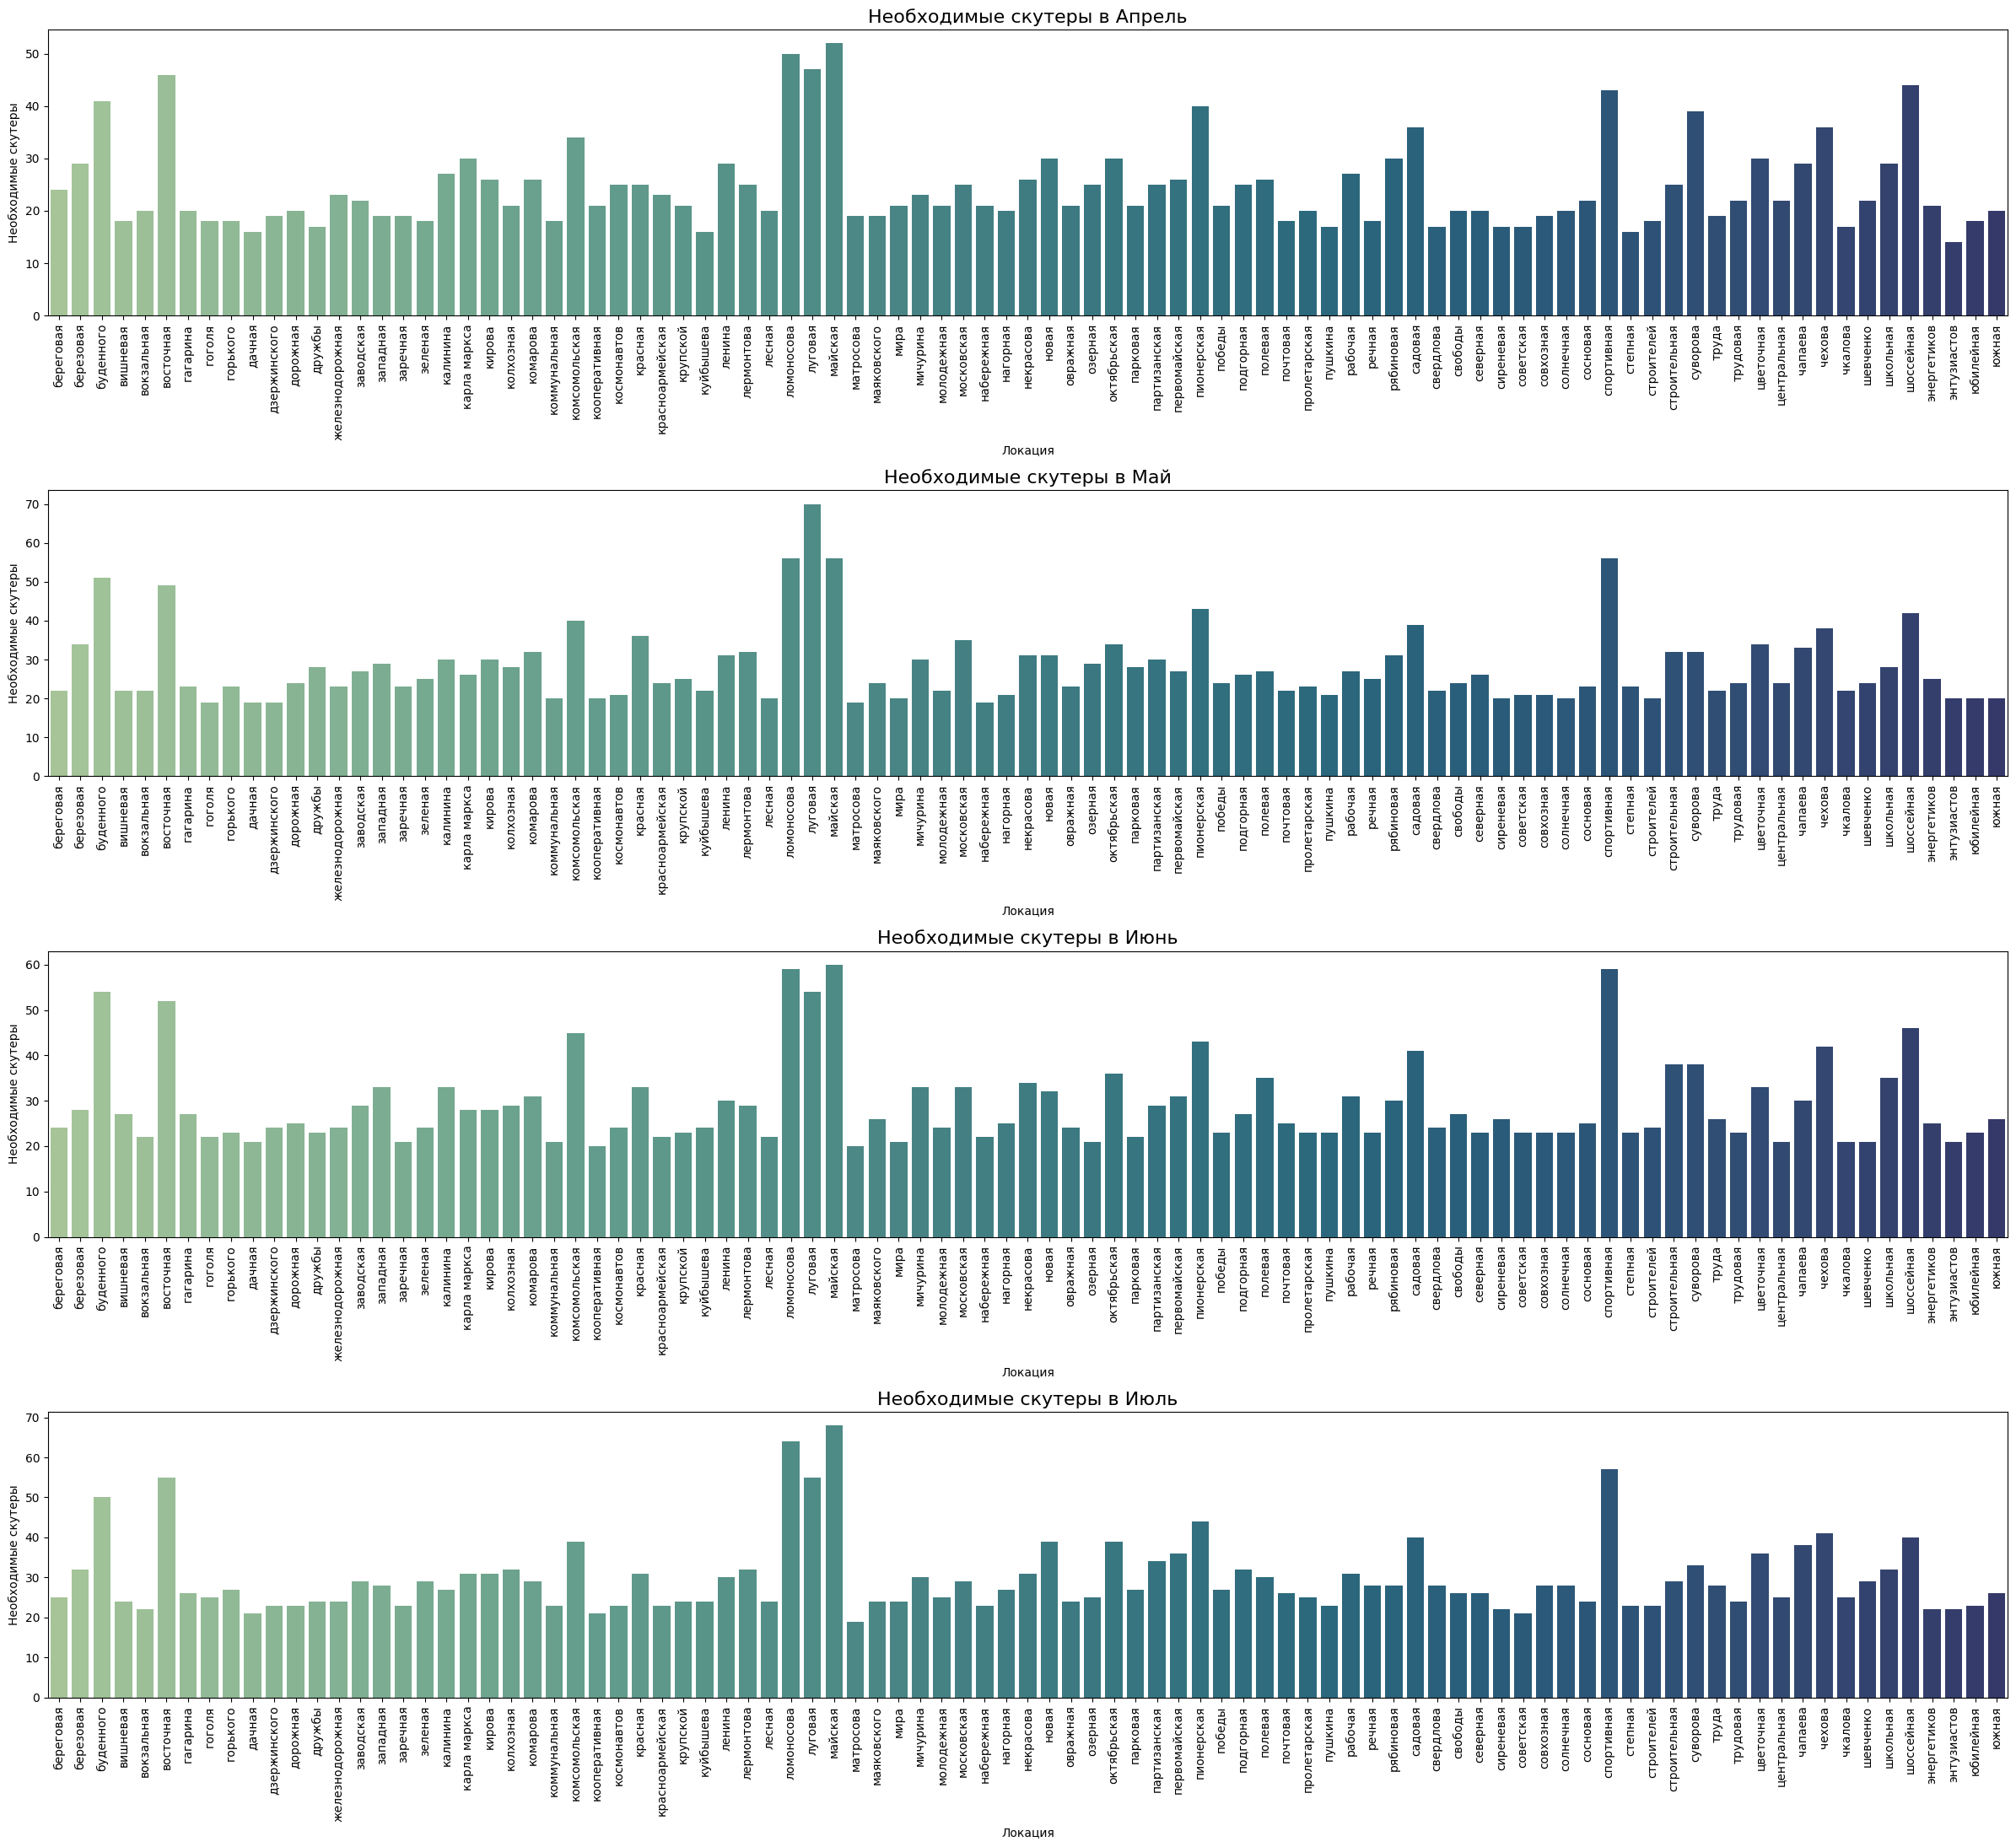

In [ ]:
unique_months = df2['month'].unique()

# Подграфики
n_months = len(unique_months)
plt.figure(figsize=(24, 22))

for i, month in enumerate(unique_months):
    plt.subplot(n_months, 1, i + 1)
    month_data = df2[df2['month'] == month]
    sns.barplot(data=month_data, x='start_location', y='need_scooters', hue='start_location', legend=False, palette='crest')
    
    plt.title(f'Необходимые скутеры в {month}', fontsize=16)
    plt.xlabel('Локация')
    plt.ylabel('Необходимые скутеры')
    plt.xticks(rotation=90)

plt.tight_layout()    
plt.show()
